In [1]:
import os
import cv2
import time
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

In [3]:
path= "C:/Users/LHH/Desktop/++71515"
train_file_0= os.listdir(path+ "/train/NORMAL")
train_file_1= os.listdir(path+ "/train/PNEUMONIA")
test_file_0= os.listdir(path+ "/test/NORMAL")
test_file_1= os.listdir(path+ "/test/PNEUMONIA")

In [4]:
X_full= 0
check= False

for file in train_file_0:
    img_in= cv2.imread(path+ "/train/NORMAL/"+ file, cv2.IMREAD_GRAYSCALE)
    img_res= cv2.resize(img_in, dsize= (100, 100), interpolation= cv2.INTER_LINEAR)
    img_round= img_res/255
    img_resh= img_round.reshape((100, 100, 1))
    img= img_resh.reshape((1, )+ img_resh.shape)
    
    if(check== False):
        X_full= img
        check= True
    else:
        X_full= np.vstack((X_full, img))

for file in train_file_1:
    img_in= cv2.imread(path+ "/train/PNEUMONIA/"+ file, cv2.IMREAD_GRAYSCALE)
    img_res= cv2.resize(img_in, dsize= (100, 100), interpolation= cv2.INTER_LINEAR)
    img_round= img_res/255
    img_resh= img_round.reshape((100, 100, 1))
    img= img_resh.reshape((1, )+ img_resh.shape)
    X_full= np.vstack((X_full, img))


In [5]:
y_full= np.array([0]* len(train_file_0))
y_full_1= np.array([1]* len(train_file_1))
y_full= np.append(y_full, y_full_1)


In [6]:
X_test, y_train= shuffle(X_full, y_full, random_state= 42)

In [7]:
X_train, X_val, y_train, y_val= train_test_split(X_full, y_full, test_size= 0.12)

In [8]:
np.save("./dataset/X_train", X_train)
np.save("./dataset/y_train", y_train)
np.save("./dataset/X_val", X_val)
np.save("./dataset/y_val", y_val)

In [9]:
X_test= 0
check= False

for file in test_file_0:
    img_in= cv2.imread(path+ "/test/NORMAL/"+ file, cv2.IMREAD_GRAYSCALE)
    img_res= cv2.resize(img_in, dsize= (100, 100), interpolation= cv2.INTER_LINEAR)
    img_round= img_res/255
    img_resh= img_round.reshape((100, 100, 1))
    img= img_resh.reshape((1, )+ img_resh.shape)
    
    if(check== False):
        X_test= img
        check= True
    else:
        X_test= np.vstack((X_test, img))

for file in test_file_1:
    img_in= cv2.imread(path+ "/test/PNEUMONIA/"+ file, cv2.IMREAD_GRAYSCALE)
    img_res= cv2.resize(img_in, dsize= (100, 100), interpolation= cv2.INTER_LINEAR)
    img_round= img_res/255
    img_resh= img_round.reshape((100, 100, 1))
    img= img_resh.reshape((1, )+ img_resh.shape)
    X_test= np.vstack((X_test, img))


In [10]:
y_test= np.array([0]* len(test_file_0))
y_test_1= np.array([1]* len(test_file_1))
y_test= np.append(y_test, y_test_1)

In [11]:
X_test, y_test= shuffle(X_test, y_test, random_state= 42)

In [12]:
np.save("./dataset/X_test", X_test)
np.save("./dataset/y_test", y_test)

In [13]:
X_train= np.load("./dataset/X_train.npy")
y_train= np.load("./dataset/y_train.npy")
X_val= np.load("./dataset/X_val.npy")
y_val= np.load("./dataset/y_val.npy")
X_test= np.load("./dataset/X_test.npy")
y_test= np.load("./dataset/y_test.npy")

In [14]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)


(10821, 100, 100, 1)
(10821,)
(1476, 100, 100, 1)
(1476,)
(2637, 100, 100, 1)
(2637,)


In [15]:
model= keras.models.Sequential()

In [16]:
model.add(keras.layers.Conv2D(64, 10, activation= "relu", padding= "same", input_shape= [100, 100, 1]))
model.add(keras.layers.MaxPooling2D(2))
model.add(keras.layers.Conv2D(128, 4, activation= "relu", padding= "same"))


model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(64, activation= "relu"))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(32, activation= "relu"))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(2, activation= "softmax"))



In [17]:
model.compile(loss= "sparse_categorical_crossentropy", optimizer= "adam", metrics= ["accuracy"])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 64)      6464      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 128)       131200    
                                                                 
 flatten (Flatten)           (None, 320000)            0         
                                                                 
 dense (Dense)               (None, 64)                20480064  
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                        

In [19]:
weight_for_0 = 1.94
weight_for_1 = 0.67

class_weight = {0: weight_for_0, 1: weight_for_1}

In [20]:
with tf.device('/GPU:0'):
    from keras.callbacks import EarlyStopping
    es=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=40)

    start_time= time.time()
    history=model.fit(X_train, y_train, epochs= 80, validation_data= (X_val, y_val), class_weight=class_weight)
    end_time= time.time()
    print("time: ", end_time- start_time)

Epoch 1/80
339/339 [==============================] - 12s 28ms/step - loss: 0.4806 - accuracy: 0.7552 - val_loss: 0.3025 - val_accuracy: 0.8645
Epoch 2/80
339/339 [==============================] - 9s 27ms/step - loss: 0.3592 - accuracy: 0.8765 - val_loss: 0.1920 - val_accuracy: 0.9336
Epoch 3/80
339/339 [==============================] - 9s 27ms/step - loss: 0.2923 - accuracy: 0.8984 - val_loss: 0.2112 - val_accuracy: 0.9207
Epoch 4/80
339/339 [==============================] - 9s 27ms/step - loss: 0.2726 - accuracy: 0.9082 - val_loss: 0.1840 - val_accuracy: 0.9343
Epoch 5/80
339/339 [==============================] - 9s 27ms/step - loss: 0.2618 - accuracy: 0.9095 - val_loss: 0.2054 - val_accuracy: 0.9207
Epoch 6/80
339/339 [==============================] - 9s 27ms/step - loss: 0.2396 - accuracy: 0.9169 - val_loss: 0.1412 - val_accuracy: 0.9411
Epoch 7/80
339/339 [==============================] - 9s 27ms/step - loss: 0.2318 - accuracy: 0.9209 - val_loss: 0.1437 - val_accuracy: 0.947

Epoch 58/80
339/339 [==============================] - 9s 27ms/step - loss: 0.0335 - accuracy: 0.9815 - val_loss: 0.1013 - val_accuracy: 0.9817
Epoch 59/80
339/339 [==============================] - 9s 27ms/step - loss: 0.0448 - accuracy: 0.9750 - val_loss: 0.0657 - val_accuracy: 0.9858
Epoch 60/80
339/339 [==============================] - 9s 27ms/step - loss: 0.0316 - accuracy: 0.9813 - val_loss: 0.0818 - val_accuracy: 0.9878
Epoch 61/80
339/339 [==============================] - 9s 27ms/step - loss: 0.0285 - accuracy: 0.9826 - val_loss: 0.0767 - val_accuracy: 0.9885
Epoch 62/80
339/339 [==============================] - 9s 27ms/step - loss: 0.0408 - accuracy: 0.9804 - val_loss: 0.0959 - val_accuracy: 0.9783
Epoch 63/80
339/339 [==============================] - 9s 27ms/step - loss: 0.0285 - accuracy: 0.9860 - val_loss: 0.0983 - val_accuracy: 0.9871
Epoch 64/80
339/339 [==============================] - 9s 27ms/step - loss: 0.0407 - accuracy: 0.9806 - val_loss: 0.0559 - val_accuracy:

In [21]:
model.save("./model/learning_model")

INFO:tensorflow:Assets written to: ./model/learning_model\assets


INFO:tensorflow:Assets written to: ./model/learning_model\assets


In [22]:
import pandas as pd
import matplotlib.pyplot as plt

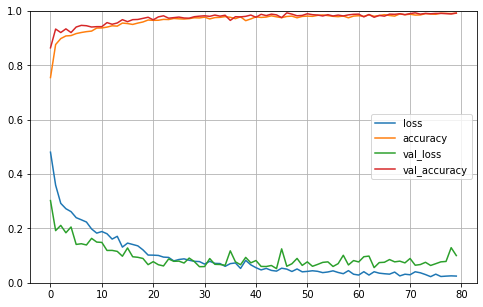

In [23]:
pd.DataFrame(history.history).plot(figsize= (8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()


In [24]:
y_pred=np.argmax(model.predict(X_test), axis=-1)
y_pred

83/83 [==============================] - 1s 10ms/step


array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [25]:
y_test

array([1, 1, 1, ..., 1, 1, 1])

In [26]:
accuracy= 0

for i in range(len(y_test)):
    if(y_test[i]== y_pred[i]).all():
        accuracy+= 1
        
print("accuracy: ", accuracy/len(y_test))

accuracy:  0.9916571861964354
